In [1]:
import matplotlib
matplotlib.rc("lines", linewidth=2)
matplotlib.rc('text', usetex=True)
matplotlib.rc("font", family="serif", serif='cmr10')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cvxpower import *

In [8]:
periods_per_hour = 60
T = 24*periods_per_hour
len_interval=1/periods_per_hour
alpha = .02*len_interval
gamma = .5*len_interval
p_load = np.array([
  0.51474725,
  0.47401232,
  0.46804122,
  0.47140148,
  0.51735674,
  0.63193182,
  0.80121667,
  0.74983225,
  0.71661753,
  0.74235491,
  0.73155551,
  0.70865584,
  0.67823632,
  0.66232903,
  0.68180769,
  0.77185203,
  0.94758236,
  1.0033142 ,
  1.02072008,
  1.16801152,
  1.30939302,
  1.11789843,
  0.8708018 ,
  0.62076654 ])
N = p_load.size
p_load = np.interp(np.arange(T), np.linspace(0,T,N), p_load)
p_load = p_load / np.max(p_load)*2

print(alpha)
print(gamma)

0.0003333333333333333
0.008333333333333333


In [ ]:
load = FixedLoad(power=p_load, name='fixed load')
gen = Generator(power_max=6, alpha=alpha, beta=0, gamma=gamma, len_interval=len_interval, name="generator")
deferrable = DeferrableLoad(time_start=8*periods_per_hour, time_end=20*periods_per_hour, energy=30, 
                            power_max=5, len_interval=len_interval, name="def. load")
storage = Storage(discharge_max=2, charge_max=2, energy_max=5, len_interval=len_interval, name='storage')
net = Net([gen.terminals[0], deferrable.terminals[0],
           load.terminals[0], storage.terminals[0]])

network = Group([gen, deferrable, load, storage], [net])
network.init_problem(time_horizon=T)
network.problem.solve(verbose=True, solver="ECOS")

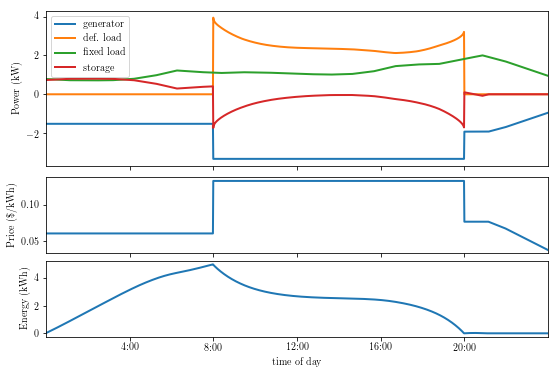

In [7]:
plt.figure(figsize=(9,6))

ticks = [t*periods_per_hour for t in [4,8,12,16,20]]
plt.subplot(211)
i = network.results.power.items()
for (d, pd) in i:
    plt.plot(pd)
plt.legend([d[0].name for (d,pd) in i], loc='upper left')
plt.ylabel("Power (kW)")
plt.xlim([0,T])
#.ylim([-2,4.5])
plt.xticks(ticks,('', '', '', '', ''))

plt.subplot(413)
plt.plot(list(network.results.price.items())[0][1]/len_interval)
plt.ylabel("Price (\$/kWh)")
plt.xlim([0,T])
plt.xticks(ticks,('', '', '', '', ''))

plt.subplot(414)
plt.plot(storage.energy.value)
plt.ylabel("Energy (kWh)")
plt.xlabel("time of day")
plt.xlim([0,T])
plt.subplots_adjust(hspace=.1)

plt.xticks(ticks, ('4:00', '8:00', '12:00', '16:00', '20:00'))

plt.savefig("home_energy_results.pdf")